# X's Community Notes analysis

Visit x.com/i/communitynotes/download-data and download the following datasets to use in the analysis:
- **Notes data**: place this file in the `data` folder.
- **Note status history data**: place this file in the `data` folder.

In [4]:
!pip install langdetect
!pip install textblob
!pip install spacy
!pip install seaborn
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP
from spacy.lang.fr.stop_words import STOP_WORDS as FR_STOP
from spacy.lang.es.stop_words import STOP_WORDS as ES_STOP
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from textblob import TextBlob
import seaborn as sns

## Separate helpful/not helpful/needs more ratings notes into three datasets

In [ ]:
# Load the file into a DataFrame
status = pd.read_csv("data/noteStatusHistory-00000.tsv", sep='\t')

/var/folders/hk/7vk84b7s5wx3wh1q4wt5_btw0000gn/T/ipykernel_93732/3598529301.py:2: DtypeWarning: Columns (10,19) have mixed types. Specify dtype option on import or set low_memory=False.
  status = pd.read_csv("data/status/noteStatusHistory-00000.tsv", sep='\t')


In [7]:
# Filter for CURRENTLY_RATED_HELPFUL
helpful_status = status[status['currentStatus'] == 'CURRENTLY_RATED_HELPFUL']

# Filter for CURRENTLY_RATED_NOT_HELPFUL
not_helpful_status = status[status['currentStatus'] == 'CURRENTLY_RATED_NOT_HELPFUL']

# Filter for NEEDS_MORE_RATINGS
needs_more_ratings_status = status[status['currentStatus'] == 'NEEDS_MORE_RATINGS']

## Filter the notes based on the status from the main notes dataset

In [8]:
# Load the file into a DataFrame
notes = pd.read_csv("data/notes/notes-00000.tsv", sep='\t')

/var/folders/hk/7vk84b7s5wx3wh1q4wt5_btw0000gn/T/ipykernel_93732/403049145.py:2: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv("data/notes/notes-00000.tsv", sep='\t')


In [9]:
# Filter notes to only include entries with noteId present in helpful_status
helpful_notes = notes[notes['noteId'].isin(helpful_status['noteId'])]

# Filter notes to only include entries with noteId present in not_helpful_status
not_helpful_notes = notes[notes['noteId'].isin(not_helpful_status['noteId'])]

# Filter notes to only include entries with noteId present in needs_more_ratings_status
needs_more_ratings = notes[notes['noteId'].isin(needs_more_ratings_status['noteId'])]

# Convert milliseconds to datetime and format to yyyy-mm-dd
helpful_notes['createdAtDate'] = pd.to_datetime(helpful_notes['createdAtMillis'], unit='ms').dt.date
not_helpful_notes['createdAtDate'] = pd.to_datetime(not_helpful_notes['createdAtMillis'], unit='ms').dt.date
needs_more_ratings['createdAtDate'] = pd.to_datetime(needs_more_ratings['createdAtMillis'], unit='ms').dt.date

/var/folders/hk/7vk84b7s5wx3wh1q4wt5_btw0000gn/T/ipykernel_93732/1888627897.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_notes['createdAtDate'] = pd.to_datetime(helpful_notes['createdAtMillis'], unit='ms').dt.date
/var/folders/hk/7vk84b7s5wx3wh1q4wt5_btw0000gn/T/ipykernel_93732/1888627897.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_helpful_notes['createdAtDate'] = pd.to_datetime(not_helpful_notes['createdAtMillis'], unit='ms').dt.date
/var/folders/hk/7vk84b7s5wx3wh1q4wt5_btw0000

## Create smaller samples of only English notes for the NLP analysis

In [37]:
# Function to detect language safely
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Apply language detection to summaries
helpful_notes['isEnglish'] = helpful_notes['summary'].apply(is_english)
not_helpful_notes['isEnglish'] = not_helpful_notes['summary'].apply(is_english)

# Filter only English summaries and take 1000
english_helpful_notes = helpful_notes[helpful_notes['isEnglish']].head(1000)
english_not_helpful_notes = not_helpful_notes[not_helpful_notes['isEnglish']].head(1000)

# Drop the helper column if you no longer need it
sample_helpful_notes = english_helpful_notes.drop(columns='isEnglish')
sample_not_helpful_notes = english_not_helpful_notes.drop(columns='isEnglish')

sample_needs_more_ratings = needs_more_ratings.sample(n=1000, random_state=42) # Set random_state for reproducibility

/tmp/ipython-input-37-2127050730.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_notes['isEnglish'] = helpful_notes['summary'].apply(is_english)
/tmp/ipython-input-37-2127050730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_helpful_notes['isEnglish'] = not_helpful_notes['summary'].apply(is_english)


In [ ]:
sample_helpful_notes.to_csv("data/notes/sample_helpful_notes.csv", index=False)
sample_not_helpful_notes.to_csv("data/notes/ample_not_helpful_notes.csv", index=False)
sample_needs_more_ratings.to_csv("data/notes/sample_needs_more_ratings.csv", index=False)

## For which kind of reasons do tweets get community notes added to them?

When you contribute by adding a community note on X, users are prompted to provide a reason (through a multiple choice checkbox) why they think the tweet needs a community note.

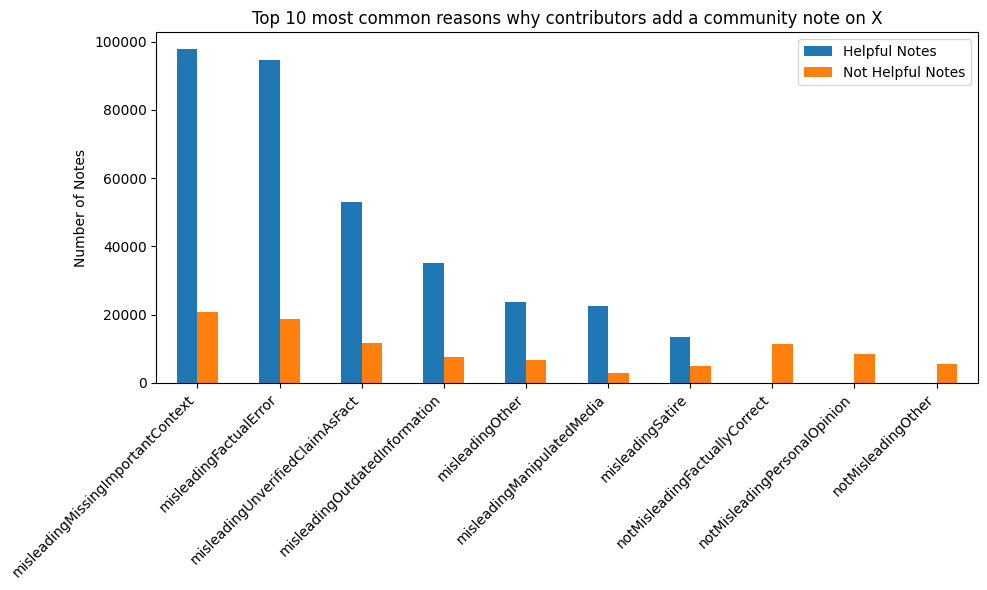

In [11]:
reasons_columns = ["misleadingOther", "misleadingFactualError", "misleadingManipulatedMedia",
                   "misleadingOutdatedInformation", "misleadingMissingImportantContext",
                   "misleadingUnverifiedClaimAsFact", "misleadingSatire", "notMisleadingOther",
                   "notMisleadingFactuallyCorrect", "notMisleadingOutdatedButNotWhenWritten",
                   "notMisleadingClearlySatire", "notMisleadingPersonalOpinion"]

# Count 1s in each reason column for both groups
helpful_counts = helpful_notes[reasons_columns].sum()
not_helpful_counts = not_helpful_notes[reasons_columns].sum()

# Combine into a DataFrame for plotting
reasons_df = pd.DataFrame({
    'Helpful Notes': helpful_counts,
    'Not Helpful Notes': not_helpful_counts
})

# Sort by total to get most common overall
reasons_df['Total'] = reasons_df['Helpful Notes'] + reasons_df['Not Helpful Notes']
reasons_df = reasons_df.sort_values(by='Total', ascending=False).drop(columns='Total')

# Keep only top 10 overall
reasons_df = reasons_df.head(10)

# Plot grouped bar chart
reasons_df.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 most common reasons why contributors add a community note on X')
plt.ylabel('Number of Notes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Most used domain names

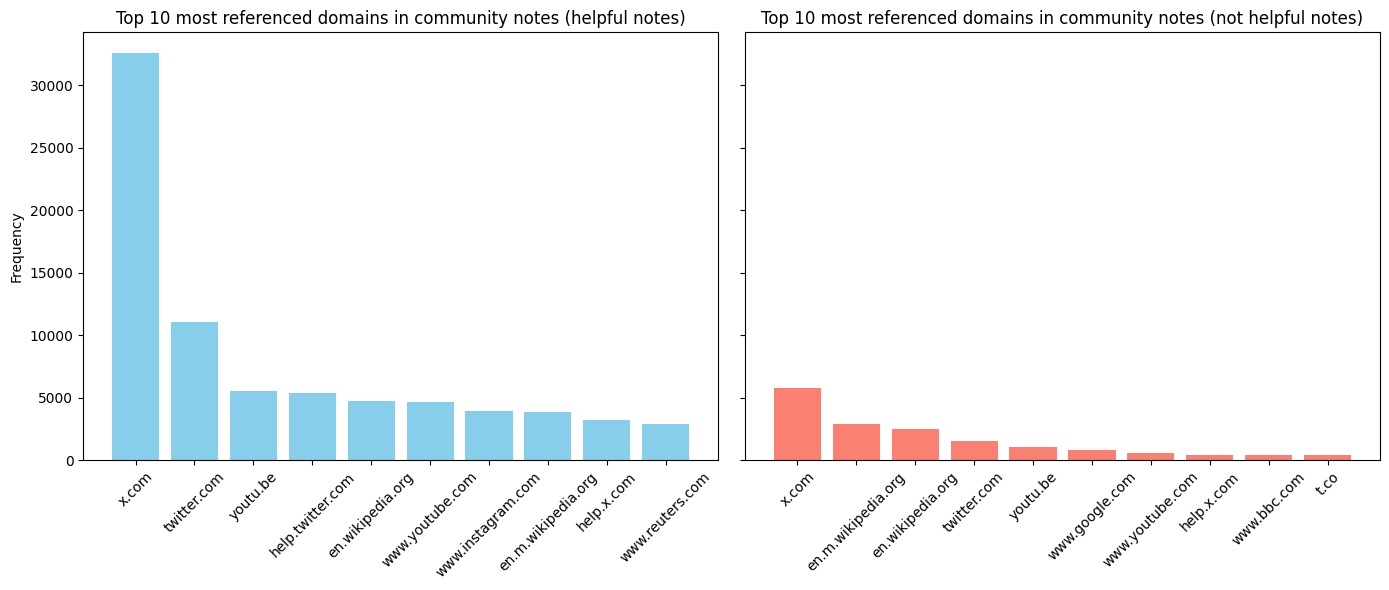

In [14]:
# Function to extract domain counts from a DataFrame
def get_domain_counts(df, column='summary'):
    all_text = ' '.join(df[column].dropna().astype(str))
    url_pattern = r'https?://[^\s)>\]]+'
    urls = re.findall(url_pattern, all_text)
    domains = []
    for url in urls:
        try:
            parsed = urlparse(url)
            if parsed.netloc:
                domains.append(parsed.netloc)
        except:
            continue
    return Counter(domains)

# Get top 10 domains separately
top_helpful = get_domain_counts(helpful_notes).most_common(10)
top_not_helpful = get_domain_counts(not_helpful_notes).most_common(10)

# Unpack domain names and counts
helpful_labels, helpful_values = zip(*top_helpful)
not_helpful_labels, not_helpful_values = zip(*top_not_helpful)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Helpful notes bar chart
axes[0].bar(helpful_labels, helpful_values, color='skyblue')
axes[0].set_title('Top 10 most referenced domains in community notes (helpful notes)')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Not helpful notes bar chart
axes[1].bar(not_helpful_labels, not_helpful_values, color='salmon')
axes[1].set_title('Top 10 most referenced domains in community notes (not helpful notes)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Person's name frequency

In [94]:
# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to extract person names from text
def extract_person_names(text):
    if pd.isna(text):
        return []
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "PERSON"]

# Apply the function to the summary column
sample_helpful_notes['person_names'] = sample_helpful_notes['summary'].apply(extract_person_names)
sample_not_helpful_notes['person_names'] = sample_not_helpful_notes['summary'].apply(extract_person_names)

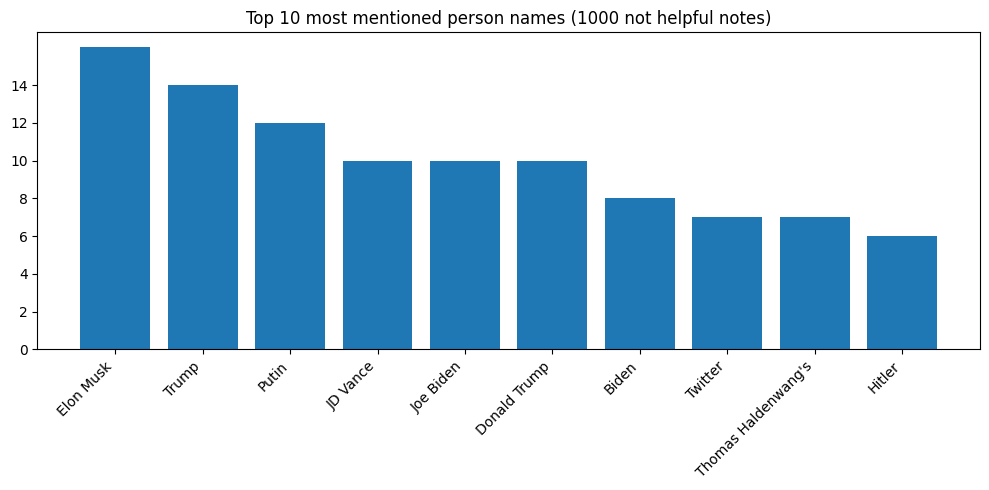

In [96]:
# Flatten the list of all person names across the dataset
all_person_names = [name for names_list in sample_not_helpful_notes['person_names'] for name in names_list]

# Count the most common person names
top_person_names = Counter(all_person_names).most_common(10)

# Unpack the top person names and their counts
names, counts = zip(*top_person_names)

# Create bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(names, counts)

# Set chart details
plt.title('Top 10 most mentioned person names (1000 not helpful notes)')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')

# Force y-axis to show integer ticks
plt.yticks(np.arange(0, max(counts), step=2))
plt.tight_layout()
plt.show()

## Word frequency

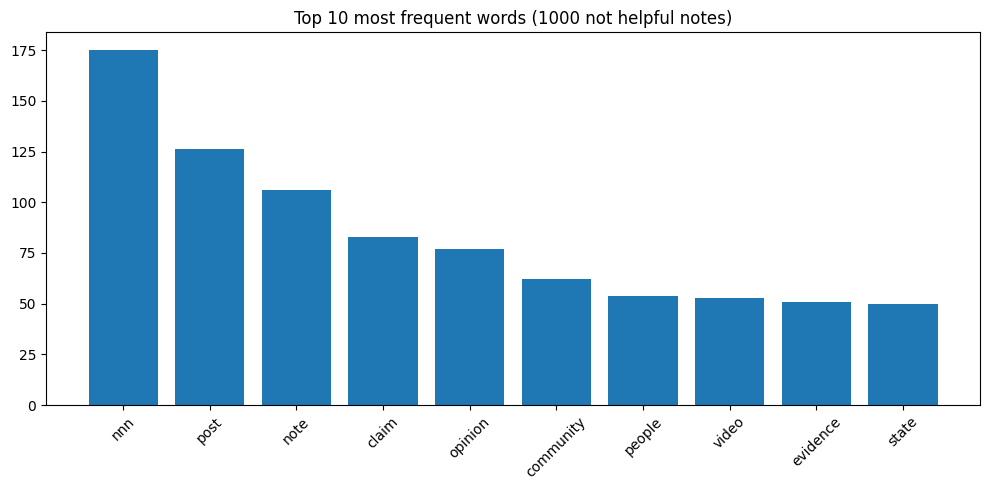

In [100]:
# Combine all stopwords into one set
all_stopwords = EN_STOP.union(FR_STOP).union(ES_STOP)

# Combine all summaries into a single string
all_summaries = ' '.join(sample_not_helpful_notes['summary'].dropna().astype(str))

# Process with spaCy
doc = nlp(all_summaries)

# Filter tokens: remove stopwords, punctuation, whitespace
words = [
    token.lemma_.lower() for token in doc
    if not token.is_stop and not token.is_punct and not token.is_space and token.lemma_.lower() not in all_stopwords
]

# Count word frequencies
word_freq = Counter(words)

# Get top 10 most common words
top_words = word_freq.most_common(10)

# Split for plotting
labels, counts = zip(*top_words)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.title('Top 10 most frequent words (1000 not helpful notes)')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Convert top word frequencies to a DataFrame
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
top_words_df.to_csv('top_10_words_not_helpful_notes.csv', index=False)

## Sentiment analysis

TextBlob uses the [Pattern](https://github.com/clips/pattern/wiki/pattern-en) library's sentiment lexicon (a rule-based system) to analyze text. This lexicon includes:

- Thousands of English words
- Each word has a predefined polarity and subjectivity score
- Some rules account for negations (e.g., “not good”) and modifiers (e.g., “very bad”)

How TextBlob scores **polarity**:

- Polarity is scored between -1.0 and 1.0 (from very negative to very positive)
- It's calculated by averaging the polarity of sentiment-bearing words in the sentence
- Words like "great" score near +0.8, "horrible" scores near -0.9
- Neutral or non-sentiment words score 0

How TextBlob scores **subjectivity**:
- Subjectivity is scored between 0.0 and 1.0 (from objective to subjective)
- Words like "I think", "believe", "amazing", "horrible" increase subjectivity
- Objective statements like "The car has four wheels" score low

> Note: TextBlob works best on short English sentences. It can struggle with sarcasm, context or domain-specific language.

In [101]:
# Functions to label polarity and subjectivity scores
def label_polarity(p):
    if p <= -0.5:
        return "Very negative"
    elif p < 0:
        return "Negative"
    elif p == 0:
        return "Neutral"
    elif p < 0.5:
        return "Positive"
    else:
        return "Very positive"

def label_subjectivity(s):
    if s < 0.3:
        return "Objective"
    elif s < 0.7:
        return "Somewhat subjective"
    else:
        return "Subjective"

# Functions for polarity and subjectivity scores
def get_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

def get_subjectivity(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

# Apply to dataframe
sample_helpful_notes['polarity'] = sample_helpful_notes['summary'].dropna().apply(get_polarity)
sample_helpful_notes['subjectivity'] = sample_helpful_notes['summary'].dropna().apply(get_subjectivity)
sample_not_helpful_notes['polarity'] = sample_not_helpful_notes['summary'].dropna().apply(get_polarity)
sample_not_helpful_notes['subjectivity'] = sample_not_helpful_notes['summary'].dropna().apply(get_subjectivity)

# Create labeled columns
sample_helpful_notes['polarity_label'] = sample_helpful_notes['polarity'].apply(label_polarity)
sample_helpful_notes['subjectivity_label'] = sample_helpful_notes['subjectivity'].apply(label_subjectivity)
sample_not_helpful_notes['polarity_label'] = sample_not_helpful_notes['polarity'].apply(label_polarity)
sample_not_helpful_notes['subjectivity_label'] = sample_not_helpful_notes['subjectivity'].apply(label_subjectivity)

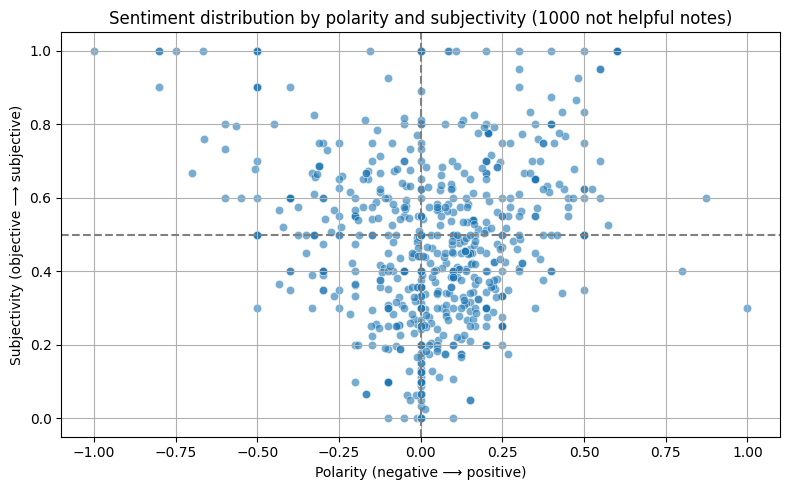

In [108]:
# Drop rows with missing sentiment scores
plot_df = sample_not_helpful_notes.dropna(subset=['summary', 'polarity', 'subjectivity'])

# Create scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x='polarity',
    y='subjectivity',
    alpha=0.6
)

plt.axvline(0, color='gray', linestyle='--')  # Neutral polarity
plt.axhline(0.5, color='gray', linestyle='--')  # Midpoint subjectivity

plt.title("Sentiment distribution by polarity and subjectivity (1000 not helpful notes)")
plt.xlabel("Polarity (negative ⟶ positive)")
plt.ylabel("Subjectivity (objective ⟶ subjective)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plot_df.to_csv("sample_helpful_notes_sentiment.csv", index=False)